In [ ]:
!pip install tensorflow matplotlib scikit-learn lime opencv-python

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import cv2
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
!unzip kdef -d /content/kdef

Archive:  kdef.zip
replace /content/kdef/angry/0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def load_kdef_data(data_path, picture_size=48, validation_split=0.2):
    # List all images in the directory
    all_images = []
    all_labels = []

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".jpg"):  # Assuming images are in jpg format
                image_path = os.path.join(root, file)
                label = os.path.basename(root)  # Folder name is the label
                all_images.append(image_path)
                all_labels.append(label)

    # Determine unique labels
    unique_labels = list(set(all_labels))
    num_classes = len(unique_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    # Split data into train and validation
    data_size = len(all_images)
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    split_index = int(data_size * (1 - validation_split))

    train_indices = indices[:split_index]
    validation_indices = indices[split_index:]

    train_images = [all_images[i] for i in train_indices]
    train_labels = [all_labels[i] for i in train_indices]

    validation_images = [all_images[i] for i in validation_indices]
    validation_labels = [all_labels[i] for i in validation_indices]

    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": train_images, "label": train_labels}),
        x_col="filename",
        y_col="label",
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": validation_images, "label": validation_labels}),
        x_col="filename",
        y_col="label",
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )

    return train_generator, validation_generator, num_classes

In [ ]:
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (5, 5), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.25),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.25),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
data_path = '/content/kdef'  # Update with your dataset path
train_generator, validation_generator, num_classes = load_kdef_data(data_path)

Found 2350 validated image filenames belonging to 7 classes.
Found 588 validated image filenames belonging to 7 classes.


In [ ]:
input_shape = next(iter(train_generator))[0].shape[1:]

# Create model
model = create_model(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
37/37 [==============================] - 21s 306ms/step - loss: 2.2530 - accuracy: 0.1626 - val_loss: 2.0996 - val_accuracy: 0.1241
Epoch 2/30
37/37 [==============================] - 10s 261ms/step - loss: 2.0414 - accuracy: 0.2306 - val_loss: 2.0345 - val_accuracy: 0.1241
Epoch 3/30
37/37 [==============================] - 9s 240ms/step - loss: 1.7398 - accuracy: 0.3302 - val_loss: 2.5074 - val_accuracy: 0.1497
Epoch 4/30
37/37 [==============================] - 10s 268ms/step - loss: 1.3134 - accuracy: 0.4894 - val_loss: 2.9956 - val_accuracy: 0.1310
Epoch 5/30
37/37 [==============================] - 12s 320ms/step - loss: 1.0736 - accuracy: 0.5881 - val_loss: 2.5981 - val_accuracy: 0.1820
Epoch 6/30
37/37 [==============================] - 10s 267ms/step - loss: 0.9508 - accuracy: 0.6226 - val_loss: 3.1828 - val_accuracy: 0.1310
Epoch 7/30
37/37 [==============================] - 9s 234ms/step - loss: 0.8356 - accuracy: 0.6643 - val_loss: 4.9855 - val_accuracy: 0.1310
E

In [ ]:
validation_loss, validation_acc = model.evaluate(validation_generator, verbose=2)
print(f'\nValidation accuracy: {validation_acc*100}')

10/10 - 2s - loss: 0.7399 - accuracy: 0.7551 - 2s/epoch - 169ms/step

Validation accuracy: 75.51020383834839


In [ ]:
# Generate predictions
predictions = model.predict(validation_generator)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels
true_classes = validation_generator.classes

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print('\nClassification Report:')
print(report)

10/10 [==============================] - 2s 159ms/step
Accuracy: 75.51%
Precision: 0.8088
Recall: 0.7551
F1 Score: 0.7582

Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.70      0.79        77
     disgust       0.80      0.91      0.85        75
        fear       0.67      0.74      0.71        98
       happy       1.00      0.87      0.93        91
     neutral       0.91      0.44      0.59        73
         sad       0.51      0.90      0.65        88
    surprise       0.89      0.69      0.78        86

    accuracy                           0.76       588
   macro avg       0.81      0.75      0.76       588
weighted avg       0.81      0.76      0.76       588



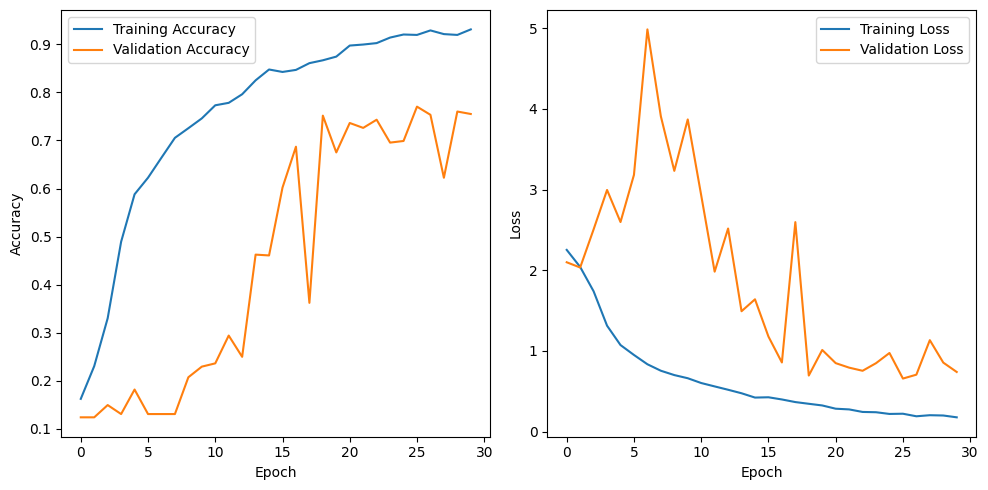

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 556ms/step


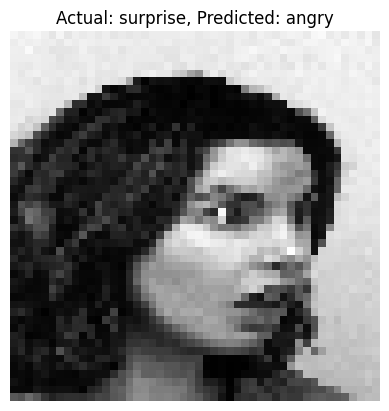

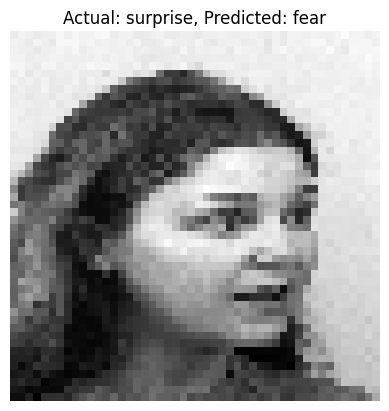

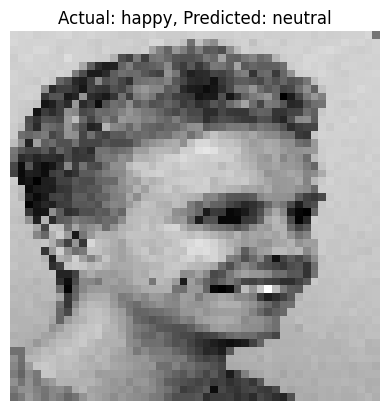

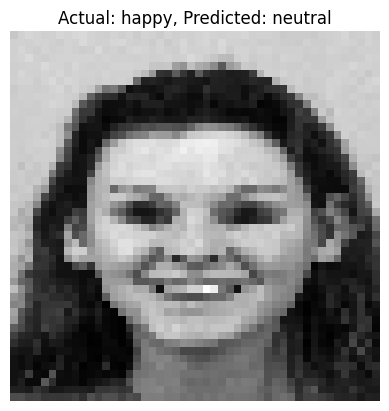

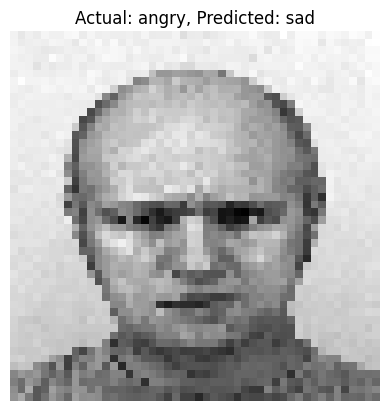

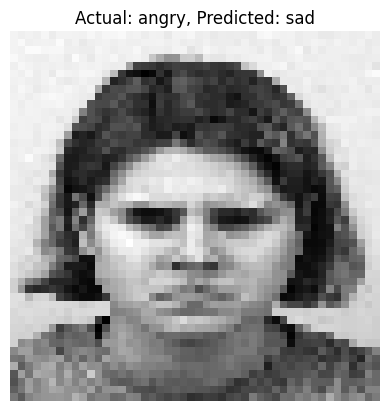

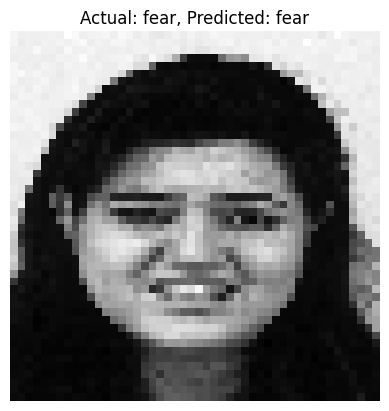

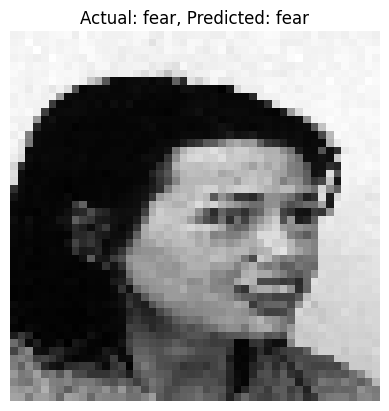

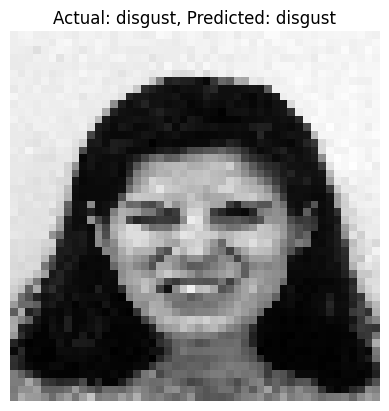

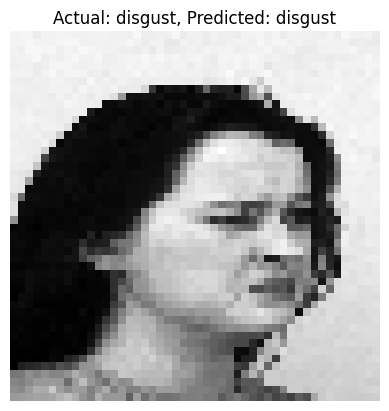

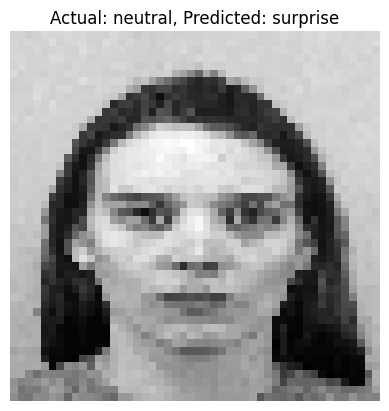

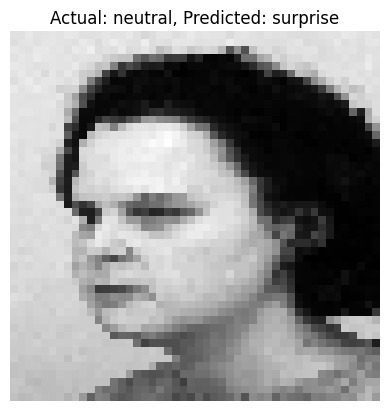

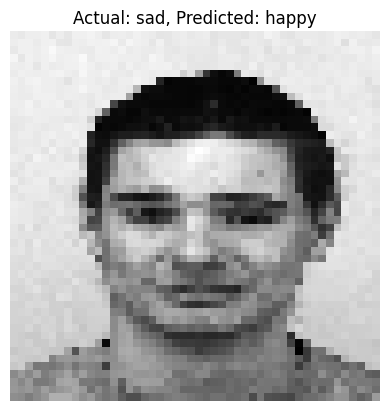

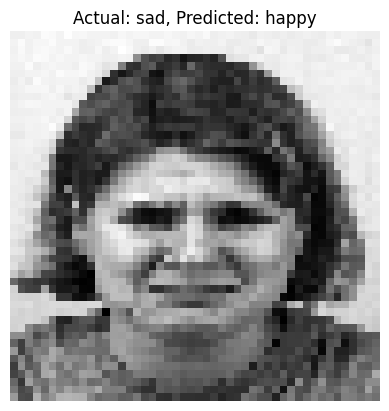

In [ ]:
def predict_and_display_results(model, data_path, picture_size=48):
    # Load the images and labels
    all_images = []
    all_labels = []

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".jpg"):  # Assuming images are in jpg format
                image_path = os.path.join(root, file)
                label = os.path.basename(root)  # Folder name is the label
                all_images.append((image_path, label))

    # Organize images by category
    category_images = {}
    for image_path, label in all_images:
        if label not in category_images:
            category_images[label] = []
        if len(category_images[label]) < 2:  # Take only the first 2 images of each category
            category_images[label].append(image_path)

    # Prepare the images for prediction
    images = []
    labels = []
    for label, paths in category_images.items():
        for path in paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=(picture_size, picture_size), color_mode='grayscale')
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            images.append(img_array)
            labels.append(label)

    images = np.vstack(images) / 255.0  # Normalize images

    # Predict using the model
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Map indices back to label names
    unique_labels = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    # Display the results
    for i, img_array in enumerate(images):
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.title(f"Actual: {labels[i]}, Predicted: {index_to_label[predicted_labels[i]]}")
        plt.axis('off')
        plt.show()

# Path to the KDEF dataset
data_path = '/content/kdef'

# Predict and display results
predict_and_display_results(model, data_path)


1/1 [==============================] - 0s 325ms/step
Predicted Label: 5, True Label: 5
Prediction Probabilities: [3.2548498e-06 8.1792905e-06 5.1490370e-05 1.4199676e-07 1.4100863e-04
 9.9979419e-01 1.8288358e-06]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


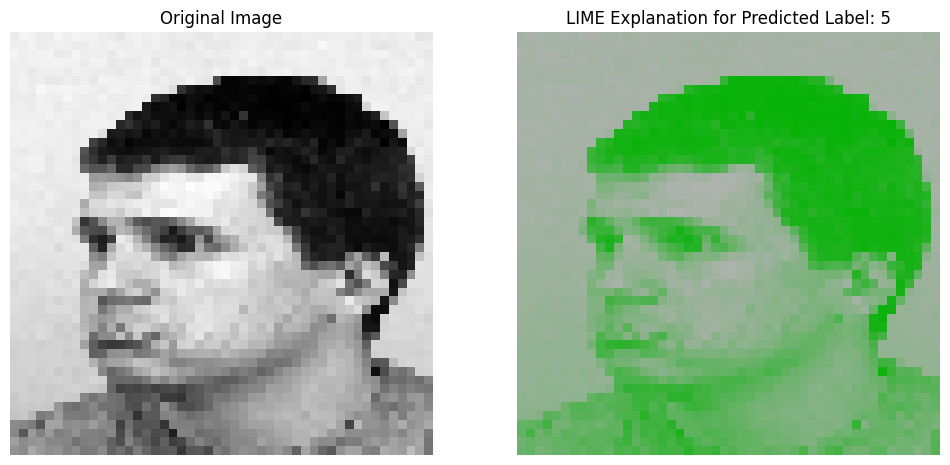

In [ ]:
# Select a sample image from the validation generator
sample_image, sample_label = next(iter(validation_generator))
sample_image = sample_image[0]
sample_label = np.argmax(sample_label[0])

# Convert the grayscale image to pseudo-RGB
sample_image_rgb = np.stack((sample_image.squeeze(),) * 3, axis=-1)

# Define the predict function
def predict_fn(images):
    # Convert pseudo-RGB images back to grayscale
    images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    images_gray = images_gray[..., np.newaxis]  # Add the channel dimension back
    return model.predict(images_gray)

# Predict the output for the sample image
prediction = predict_fn([sample_image_rgb])[0]
predicted_label = np.argmax(prediction)

# Print the predicted output
print(f"Predicted Label: {predicted_label}, True Label: {sample_label}")
print(f"Prediction Probabilities: {prediction}")

# Create a LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the sample image
explanation = explainer.explain_instance(sample_image_rgb, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Get the image and mask for the top predicted label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Display the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display the explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation for Predicted Label: {predicted_label}')
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 21ms/step
Predicted Label: happy, True Label: happy
Prediction Probabilities: [1.4515032e-06 8.0623655e-03 2.6722421e-04 9.9164492e-01 6.9866373e-06
 1.6877899e-05 1.7208473e-07]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


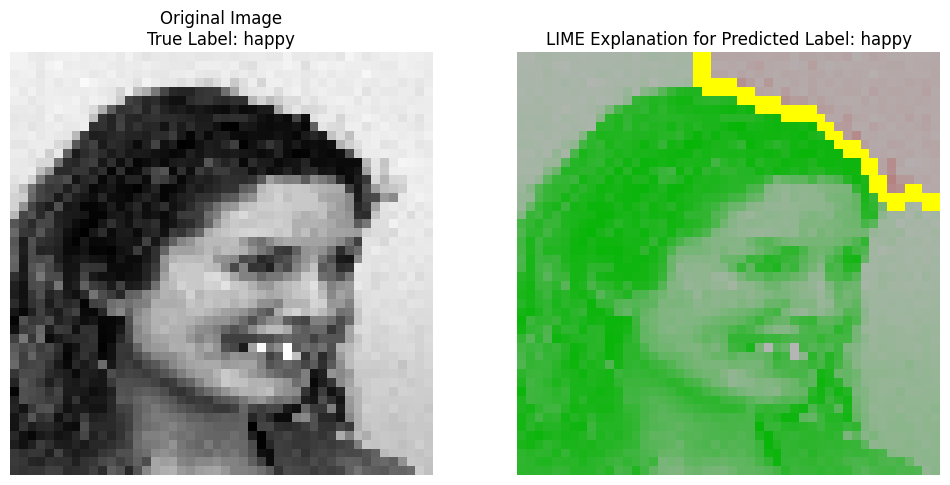

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2

# Define label names based on your dataset
label_names = validation_generator.class_indices

# Select a sample image from the validation generator
sample_image, sample_label = next(iter(validation_generator))
sample_image = sample_image[0]
sample_label = np.argmax(sample_label[0])

# Convert the grayscale image to pseudo-RGB
sample_image_rgb = np.stack((sample_image.squeeze(),) * 3, axis=-1)

# Define the predict function
def predict_fn(images):
    # Convert pseudo-RGB images back to grayscale
    images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    images_gray = images_gray[..., np.newaxis]  # Add the channel dimension back
    return model.predict(images_gray)

# Predict the output for the sample image
prediction = predict_fn([sample_image_rgb])[0]
predicted_label_idx = np.argmax(prediction)
predicted_label_name = list(label_names.keys())[predicted_label_idx]

true_label_idx = sample_label
true_label_name = list(label_names.keys())[true_label_idx]

# Print the predicted output
print(f"Predicted Label: {predicted_label_name}, True Label: {true_label_name}")
print(f"Prediction Probabilities: {prediction}")

# Create a LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the sample image
explanation = explainer.explain_instance(sample_image_rgb, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Get the image and mask for the top predicted label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label_idx,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Display the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f'Original Image\nTrue Label: {true_label_name}')
plt.axis('off')

# Display the explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation for Predicted Label: {predicted_label_name}')
plt.axis('off')

plt.show()


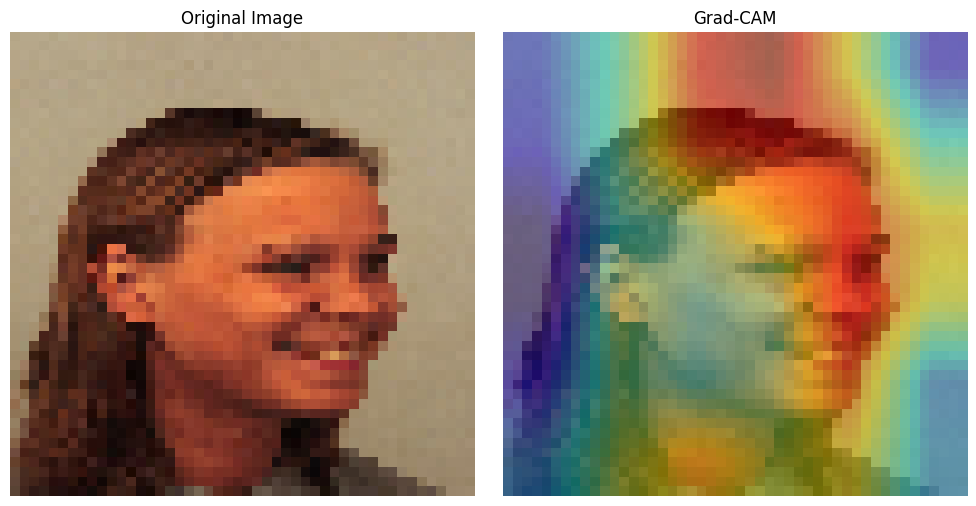

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

def get_gradcam_heatmap(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = K.mean(grads, axis=(0, 1))

    output = output.numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        output[..., i] *= pooled_grads[i]

    heatmap = np.mean(output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def display_gradcam(model, img_path, layer_name, picture_size=48):
    img = image.load_img(img_path, target_size=(picture_size, picture_size), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    heatmap = get_gradcam_heatmap(model, img_array, layer_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (picture_size, picture_size))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Ensure heatmap is of type CV_8UC1
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
sample_img_path = '/content/kdef/happy/0_30.jpg'  # Replace with the path to your sample image
last_conv_layer_name = 'conv2d_3'  # Replace with the name of your last convolutional layer

display_gradcam(model, sample_img_path, last_conv_layer_name)


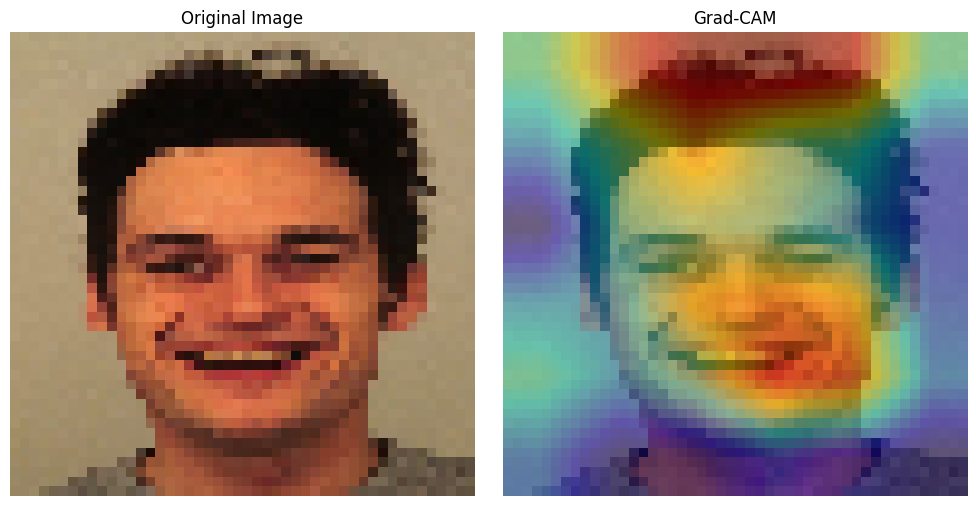

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

def get_gradcam_heatmap(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = K.mean(grads, axis=(0, 1))

    output = output.numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        output[..., i] *= pooled_grads[i]

    heatmap = np.mean(output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def display_gradcam(model, img_path, layer_name, picture_size=48):
    img = image.load_img(img_path, target_size=(picture_size, picture_size), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    heatmap = get_gradcam_heatmap(model, img_array, layer_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (picture_size, picture_size))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Ensure heatmap is of type CV_8UC1
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
sample_img_path = '/content/kdef/happy/100_10.jpg'  # Replace with the path to your sample image
last_conv_layer_name = 'conv2d_3'  # Replace with the name of your last convolutional layer

display_gradcam(model, sample_img_path, last_conv_layer_name)


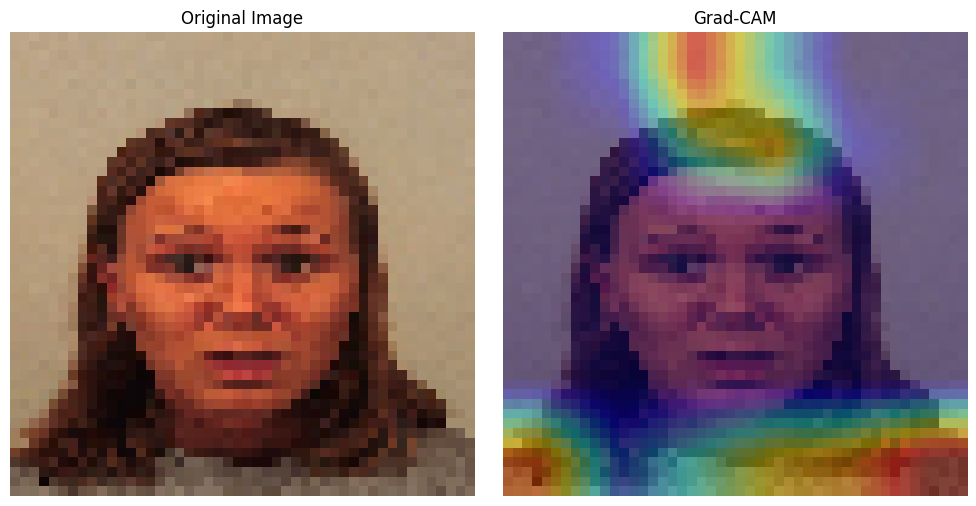

In [ ]:

sample_img_path = '/content/kdef/fear/0_26.jpg'
display_gradcam(model, sample_img_path, last_conv_layer_name)


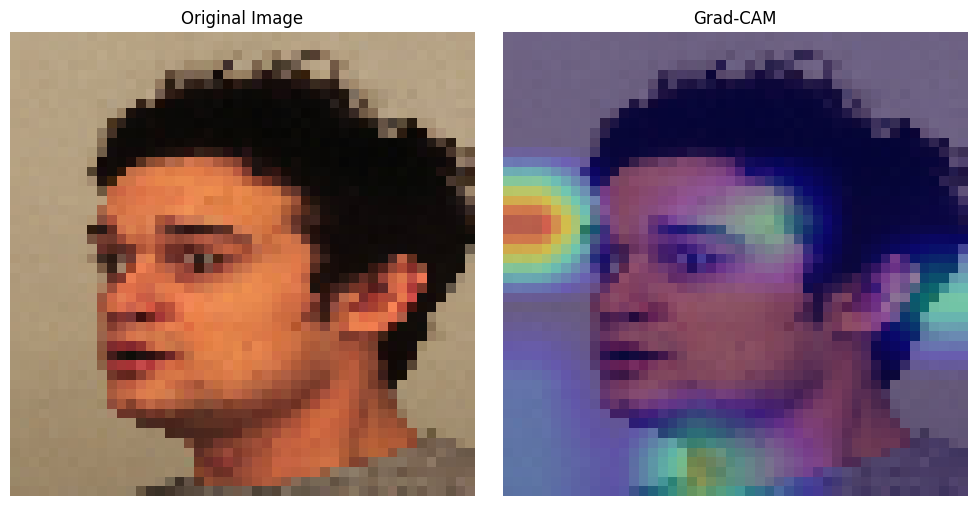

In [ ]:
sample_img_path = '/content/kdef/fear/100_11.jpg'
display_gradcam(model, sample_img_path, last_conv_layer_name)

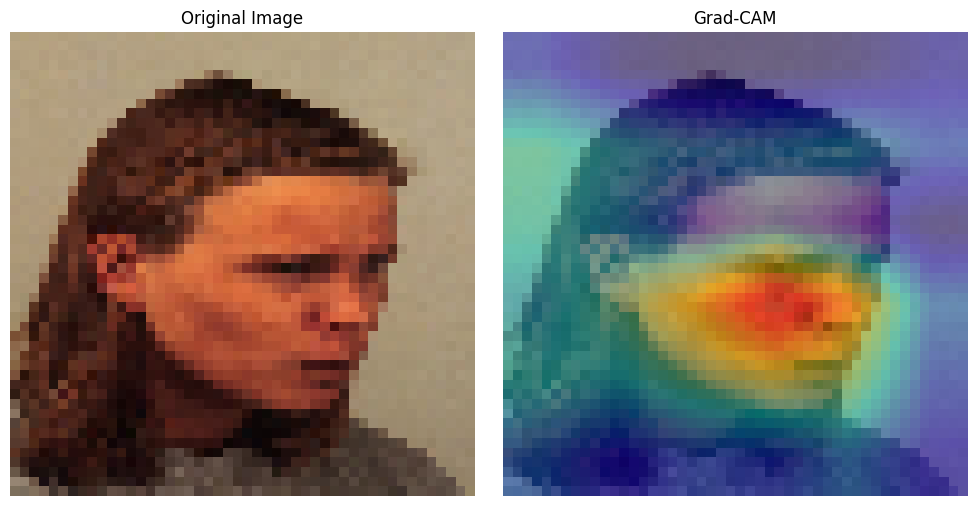

In [ ]:
sample_img_path = '/content/kdef/angry/0_0.jpg'
display_gradcam(model, sample_img_path, last_conv_layer_name)

1/1 [==============================] - 0s 35ms/step
Predicted class: [3]
Predicted label: happy


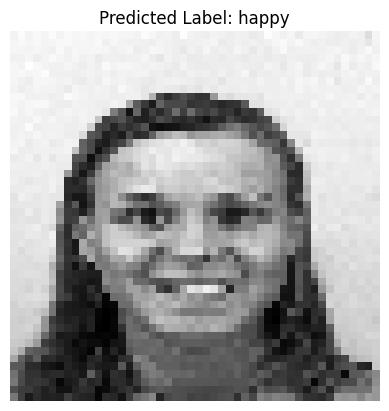

In [ ]:
def predict_emotion(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

def get_label_from_class_index(index, label_to_index):
    index_to_label = {v: k for k, v in label_to_index.items()}
    return index_to_label.get(index, "Unknown")

image_path = '/content/kdef/happy/0_24.jpg'

# Predict the emotion
predicted_class = predict_emotion(image_path)
print(f'Predicted class: {predicted_class}')

# Assuming you have the label_to_index mapping from the data loading step
label_to_index = train_generator.class_indices

predicted_label = get_label_from_class_index(predicted_class[0], label_to_index)
print(f'Predicted label: {predicted_label}')

# Display the image along with the predicted label
img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()
